For the analysis that we had created before, Ricardo and I had noticed that there were some discrepancies in the generation of the descriptive statistics. 

The calculations were being performed properly, however, the dataset that we were using was spread out over too large of an area (Bueno Aires is an area of 200 km$^2$, whereas Sydney's Urban Centre Locality was 3,483 km$^2$. We decided to do the following: 

1. Create a new dataframe that aggregates the data by the hex-ID
2. Perform a spatial join with the newly generated groupby dataframe and then aggregate the statistics from that 
3. Comparing the absolute values of tweets within a hexagon between two periods instead of the percentage change
4. Aggregate the data in two periods, but instead of taking the average of both periods, count the total number of tweets in each period
    * Consider dropping a period of data because of the missing data in 2015. 
5. Cut the lat/lon for the Sydney.plot('')


In [1]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import datetime

# 0. Connect to Mongo and define a specific database

In [2]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [3]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

1.9915556907653809


In [4]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 12.6+ MB


In [6]:
# create a groupby on the time so that we can know which time frames to remove from both periods of analysis 
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
time,,,,
2012-09-30,229761.0,211742.0,30339.0,260100.0
2012-12-31,356359.0,323790.0,61568.0,417927.0
2013-03-31,419450.0,380960.0,70364.0,489814.0
2013-06-30,366380.0,331778.0,67054.0,433434.0
2013-09-30,387275.0,356669.0,62135.0,449410.0
2013-12-31,554401.0,509939.0,89274.0,643675.0
2014-03-31,469416.0,429404.0,88440.0,557856.0
2014-06-30,446140.0,402041.0,84390.0,530530.0
2014-09-30,332426.0,303115.0,63688.0,396114.0


Technically, if we were to just count time periods, five quarter (trimestres) after our second observation period is `2015-12-31`, so the equivalent of that from the first time period is `2013-09-30`. I'm going to remove all observations from that time. 

In [7]:
# create a variable indexnames where it is the dataframe where it == the two periods we want to drop for obs.
indexnames1 = df[df['time'] == '2013-09-30' ].index
indexnames2 = df[df['time'] == '2015-12-31' ].index

In [8]:
# Delete these row indexes from dataFrame
df.drop(indexnames1 , inplace=True)
df.drop(indexnames2 , inplace=True)

In [9]:
# create variable that is the dt value for our observation period
datebeforeandafterperiod=datetime.datetime(2014,9,30)
# create a dummy variable based on dt value above
df['period']=np.where(df.time>datebeforeandafterperiod,1,0)

In [10]:
df2=df.groupby(['_id','period']).mean()
df2.reset_index(inplace=True)

In [12]:
df2

,_id,period,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
0,89be08182dbffff,0,1.000000,1.000000,NaN,1.000000
1,89be08186d3ffff,1,2.000000,2.000000,NaN,2.000000
2,89be08191bbffff,1,2.000000,2.000000,NaN,2.000000
3,89be081920fffff,0,3.000000,3.000000,NaN,3.000000
4,89be0819223ffff,0,1.000000,1.000000,NaN,1.000000
...,...,...,...,...,...,...
31345,89be0e373bbffff,1,33.000000,31.250000,1.875000,34.875000
31346,89be0eacb27ffff,0,0.857143,0.857143,NaN,0.857143
31347,89be0eacb27ffff,1,1.250000,1.250000,2.000000,1.500000
31348,89be0eacb2fffff,0,0.571429,0.571429,0.666667,0.857143


In [13]:
df2.set_index('_id',inplace=True)

In [14]:
# Diferences between each of the variables within the different periods 
df2dif = df2.groupby('_id')[['nonresidents', 'nonresidentsandnonneighbors', 'residents', 
                             'totalcounts','period']].diff(1)

In [15]:
df2dif.head(-10)

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,period
_id,,,,,
89be08182dbffff,NaN,NaN,NaN,NaN,NaN
89be08186d3ffff,NaN,NaN,NaN,NaN,NaN
89be08191bbffff,NaN,NaN,NaN,NaN,NaN
89be081920fffff,NaN,NaN,NaN,NaN,NaN
89be0819223ffff,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
89be0e373a3ffff,-50.625,-59.375,3.750000,-46.875,1.0
89be0e373a7ffff,NaN,NaN,NaN,NaN,NaN
89be0e373a7ffff,27.875,29.250,-27.660714,7.000,1.0


In [16]:
df2dif=df2dif.reset_index()
df2dif=df2dif.loc[df2dif.period==1]

In [17]:
df2dif

,_id,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,period
32,89be0819e4bffff,-0.375000,-0.375000,NaN,-0.375000,1.0
40,89be081a053ffff,-0.333333,-0.333333,NaN,-0.333333,1.0
43,89be081a08bffff,1.266667,1.266667,NaN,1.266667,1.0
45,89be081a08fffff,0.333333,0.333333,NaN,0.333333,1.0
49,89be081a0cfffff,-0.250000,-0.250000,NaN,-0.250000,1.0
...,...,...,...,...,...,...
31341,89be0e373afffff,-139.000000,-125.250000,26.000,-137.125000,1.0
31343,89be0e373b7ffff,-2.875000,-2.875000,NaN,-2.875000,1.0
31345,89be0e373bbffff,-6.714286,-8.321429,0.875,-5.410714,1.0
31347,89be0eacb27ffff,0.392857,0.392857,NaN,0.642857,1.0


In [18]:
df2b=df2.reset_index()
df20=df2b.loc[df2b.period==0]

In [19]:
df2b

,_id,period,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
0,89be08182dbffff,0,1.000000,1.000000,NaN,1.000000
1,89be08186d3ffff,1,2.000000,2.000000,NaN,2.000000
2,89be08191bbffff,1,2.000000,2.000000,NaN,2.000000
3,89be081920fffff,0,3.000000,3.000000,NaN,3.000000
4,89be0819223ffff,0,1.000000,1.000000,NaN,1.000000
...,...,...,...,...,...,...
31345,89be0e373bbffff,1,33.000000,31.250000,1.875000,34.875000
31346,89be0eacb27ffff,0,0.857143,0.857143,NaN,0.857143
31347,89be0eacb27ffff,1,1.250000,1.250000,2.000000,1.500000
31348,89be0eacb2fffff,0,0.571429,0.571429,0.666667,0.857143


In [20]:
# Junto todo en un merge
dfnew=df2dif.merge(df20, left_on='_id', right_on='_id', suffixes=('_dif', '_p0'))
dfnew=dfnew.drop(columns=['period_dif', 'period_p0'])

In [21]:
# computo las tasas de crecimiento en las variables _ch
for var in ['nonresidents', 'nonresidentsandnonneighbors','residents','totalcounts']:
    dfnew[var+'_ch']=dfnew[var+'_dif']/dfnew[var+'_p0']

In [23]:
# Las versiones b de las tasas de crecimiento son solo las tasas para aquellos lugares que tenian mas de 50 tweets en periodo 0
for var in ['nonresidents', 'nonresidentsandnonneighbors','residents','totalcounts']:
    dfnew[var+'_ch'+'b']=np.where(dfnew[var+'_p0']>50,dfnew[var+'_ch'],np.NaN)

In [24]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13531 entries, 0 to 13530
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              13531 non-null  object 
 1   nonresidents_dif                 13456 non-null  float64
 2   nonresidentsandnonneighbors_dif  13390 non-null  float64
 3   residents_dif                    2186 non-null   float64
 4   totalcounts_dif                  13531 non-null  float64
 5   nonresidents_p0                  13503 non-null  float64
 6   nonresidentsandnonneighbors_p0   13479 non-null  float64
 7   residents_p0                     4411 non-null   float64
 8   totalcounts_p0                   13531 non-null  float64
 9   nonresidents_ch                  13456 non-null  float64
 10  nonresidentsandnonneighbors_ch   13390 non-null  float64
 11  residents_ch                     2186 non-null   float64
 12  totalcounts_ch    

In [25]:
dfnew.describe()

,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb
count,13456.000000,13390.000000,2186.000000,13531.000000,13503.000000,13479.000000,4411.000000,13531.000000,1.345600e+04,1.339000e+04,2186.000000,1.353100e+04,1426.000000,1293.000000,317.000000,1726.000000
mean,-12.062177,-10.596630,-6.009771,-14.518216,29.730202,27.157062,27.014226,34.785086,inf,inf,inf,inf,-0.481756,-0.465579,-0.427613,-0.507807
std,157.329863,153.884155,95.459560,162.565261,136.052031,123.744757,75.294407,149.551844,NaN,NaN,NaN,NaN,2.445557,2.597959,1.209861,2.045437
min,-2606.250000,-2196.625000,-1381.250000,-2882.875000,0.000000,0.000000,0.000000,0.000000,-9.988854e-01,-9.983424e-01,-0.999079,-9.988854e-01,-0.998885,-0.998342,-0.999079,-0.998885
25%,-10.086310,-9.107143,-14.000000,-12.375000,1.750000,1.666667,3.000000,2.000000,-7.543860e-01,-7.469062e-01,-0.774446,-7.714286e-01,-0.887712,-0.887538,-0.924861,-0.898586
50%,-1.850000,-1.666667,-1.857143,-2.208333,5.571429,5.000000,9.000000,6.750000,-4.814815e-01,-4.704858e-01,-0.333333,-5.000000e-01,-0.698998,-0.683570,-0.736878,-0.717606
75%,0.257143,0.250000,3.333333,0.259524,18.375000,16.375000,24.000000,22.142857,2.000000e-01,2.021008e-01,1.000000,2.000000e-01,-0.483246,-0.474609,-0.439380,-0.503121
max,15673.750000,15674.750000,1660.666667,15664.750000,6080.375000,5669.250000,2507.000000,6450.250000,inf,inf,inf,inf,81.316472,82.552995,12.535354,74.594048


## 2. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [26]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

# read the new file 
tracts = gpd.read_file(shp_path/"syd.geojson")
# print
tracts = tracts.to_crs('EPSG:4326')

In [27]:
tracts.AREASQKM16.sum()

3482.7441

In [28]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SA2_MAIN16          265 non-null    object  
 1   SA2_5DIG16          265 non-null    object  
 2   SA2_NAME16          265 non-null    object  
 3   SA3_CODE16          265 non-null    object  
 4   SA3_NAME16          265 non-null    object  
 5   SA4_CODE16          265 non-null    object  
 6   SA4_NAME16          265 non-null    object  
 7   GCC_CODE16          265 non-null    object  
 8   GCC_NAME16          265 non-null    object  
 9   STE_CODE16          265 non-null    object  
 10  STE_NAME16          265 non-null    object  
 11  AREASQKM16          265 non-null    float64 
 12  OID                 265 non-null    int64   
 13  SA2_MAINCODE_2016   265 non-null    int64   
 14  rentals_ov100_11    265 non-null    int64   
 15  types               265 non-null

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

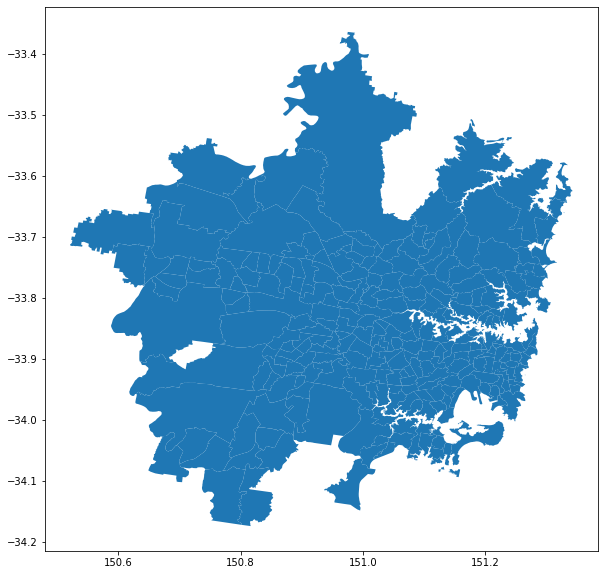

In [29]:
tracts.plot()

tracts.crs

In [30]:
# Create a geodataframe out of the grouped hex dataframe `df2`
gdf = myh3.df_with_hexid_to_gdf(dfnew, hexcolname='_id')

In [31]:
# Create a dataframe agg_gdf out of the tracts above and the geodataframe we created before 
agg_gdf = gpd.sjoin(gdf,tracts,how='inner',op='intersects')

In [32]:
agg_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17903 entries, 0 to 13471
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   _id                              17903 non-null  object  
 1   nonresidents_dif                 17816 non-null  float64 
 2   nonresidentsandnonneighbors_dif  17738 non-null  float64 
 3   residents_dif                    2989 non-null   float64 
 4   totalcounts_dif                  17903 non-null  float64 
 5   nonresidents_p0                  17872 non-null  float64 
 6   nonresidentsandnonneighbors_p0   17843 non-null  float64 
 7   residents_p0                     5997 non-null   float64 
 8   totalcounts_p0                   17903 non-null  float64 
 9   nonresidents_ch                  17816 non-null  float64 
 10  nonresidentsandnonneighbors_ch   17738 non-null  float64 
 11  residents_ch                     2989 non-null   float64 
 

In [40]:
agg_group = agg_gdf[['nonresidents_dif','nonresidents_p0',
         'nonresidentsandnonneighbors_dif','nonresidentsandnonneighbors_p0',
         'standardized_types']
       ].groupby('standardized_types').agg(['mean',
                                            'median',
                                            'count',
                                            'sem'])
agg_group

nonresidents_dif                            \
                                          mean    median count       sem   
standardized_types                                                         
Exclusive Dynamic                   -14.018971 -1.428571  3958  1.059120   
Exclusive Static                    -14.154340 -1.541667  5263  1.058090   
Low Income, At Risk of Change       -18.566557 -3.970238  3308  5.311911   
Low Income, Stable                   -6.334704 -1.325000  2097  0.787566   
Low Income, Undergoing Change       -10.333544 -3.014286  3190  1.181990   

                              nonresidents_p0                            \
                                         mean    median count       sem   
standardized_types                                                        
Exclusive Dynamic                   31.189778  5.000000  3969  1.774011   
Exclusive Static                    30.787739  5.000000  5280  1.586163   
Low Income, At Risk of Change       52.405819  9.125000  3317  4.199789   
Low Income, Stable                  13.842979  4.125000  2107  0.701015   
Low Income, Undergoing Change       23.054868  7.428571  3199  0.978405   

                              nonresidentsandnonneighbors_dif                  \
                                                         mean    median count   
standardized_types                                                              
Exclusive Dynamic                                  -12.719502 -1.375000  3943   
Exclusive Static                                   -12.613871 -1.428571  5233   
Low Income, At Risk of Change                      -15.498813 -3.622024  3298   
Low Income, Stable                                  -5.670903 -1.250000  2083   
Low Income, Undergoing Change                       -9.018176 -2.714286  3181   

                                        nonresidentsandnonneighbors_p0  \
                                    sem                           mean   
standardized_types                                                       
Exclusive Dynamic              0.975814                      28.832285   
Exclusive Static               0.991021                      28.154894   
Low Income, At Risk of Change  5.213431                      47.177921   
Low Income, Stable             0.751185                      12.687807   
Low Income, Undergoing Change  1.138150                      21.014823   

                                                         
                                 median count       sem  
standardized_types                                       
Exclusive Dynamic              4.625000  3962  1.654236  
Exclusive Static               4.571429  5273  1.453266  
Low Income, At Risk of Change  8.250000  3314  3.787475  
Low Income, Stable             3.875000  2101  0.662042  
Low Income, Undergoing Change  6.750000  3193  0.897063

In [41]:
agg_group2 = agg_gdf[['residents_dif','residents_p0',
         'totalcounts_dif','totalcounts_p0','standardized_types']].groupby('standardized_types').agg(
    ['mean','median','count','sem'])
agg_group2

residents_dif                            \
                                       mean    median count       sem   
standardized_types                                                      
Exclusive Dynamic                 -5.188742 -1.857143   760  1.937130   
Exclusive Static                  -7.862294 -2.437500   902  3.422159   
Low Income, At Risk of Change    -11.437982 -3.000000   633  4.425862   
Low Income, Stable                 1.917270 -1.041667   213  5.797951   
Low Income, Undergoing Change     -1.099948 -0.533333   481  5.078221   

                              residents_p0                            \
                                      mean    median count       sem   
standardized_types                                                     
Exclusive Dynamic                24.882537  8.285714  1307  2.325421   
Exclusive Static                 27.560014  9.000000  1717  1.701192   
Low Income, At Risk of Change    31.667932  9.633333  1302  2.080629   
Low Income, Stable               20.430399  8.500000   551  1.550619   
Low Income, Undergoing Change    25.476626  9.000000  1120  1.848254   

                              totalcounts_dif                            \
                                         mean    median count       sem   
standardized_types                                                        
Exclusive Dynamic                  -16.674721 -1.663690  3980  1.169316   
Exclusive Static                   -16.798948 -1.875000  5290  1.228584   
Low Income, At Risk of Change      -22.562837 -4.942857  3320  5.419452   
Low Income, Stable                  -7.201785 -1.583333  2111  0.904200   
Low Income, Undergoing Change      -12.728375 -3.571429  3202  1.315376   

                              totalcounts_p0                             
                                        mean     median count       sem  
standardized_types                                                       
Exclusive Dynamic                  36.237969   5.875000  3980  1.951216  
Exclusive Static                   36.376417   6.125000  5290  1.790378  
Low Income, At Risk of Change      60.199441  11.000000  3320  4.587326  
Low Income, Stable                 16.261043   5.000000  2111  0.792842  
Low Income, Undergoing Change      27.508257   9.142857  3202  1.149440

In [ ]:
agg_group.info()

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(agg_group.index, agg_group['nonresidents','mean'], yerr=1.96*agg_group['nonresidents','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
agg_group.loc[agg_group.nonresidents<8].nonresidents_ch.hist()

In [ ]:
barchart(tweets_tracts, 'nonresidents_ch', title="Non residents percent change")

In [ ]:
barchart(tweets_tracts, 'nonresidents_dif', title="Non residents differences")